In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, color
import cv2
import tensorflow as tf
from keras_segmentation.models.model_utils import get_segmentation_model
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.predict import predict

In [3]:
import sys
print(sys.version)

3.8.3 (v3.8.3:6f8c8320e9, May 13 2020, 16:29:34) 
[Clang 6.0 (clang-600.0.57)]


In [4]:
# load in dataset
df = pd.read_pickle('../Data/training.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   r_ppl     21576 non-null  object
 1   g_ppl     21576 non-null  object
 2   b_ppl     21576 non-null  object
 3   r_xpl     21576 non-null  object
 4   g_xpl     21576 non-null  object
 5   b_xpl     21576 non-null  object
 6   labels    21576 non-null  object
 7   rotation  21576 non-null  object
 8   topleft   21576 non-null  object
dtypes: object(9)
memory usage: 1.5+ MB


In [5]:
# save 6 channel png
# merge 6 color channels 
def merge_channels(row):
    '''merge RGB color channels,
    convert to float, and divide by 255'''
    return np.dstack((row['r_ppl'], row['g_ppl'], row['b_ppl'], 
        row['r_xpl'], row['g_xpl'], row['b_ppl'])).astype('float')

# create a copy of the original df to manipulate
# shuffle dataframe to randomize order of images
X = df.sample(frac=1, random_state=2).reset_index(drop=True)

# create a column that combines pixel data
X['img'] = df.apply(merge_channels, axis=1)

# create a train, validation, and test set split 80, 10, 10, respectively
train, validate, test = np.split(X, [int(.8*len(df)), int(.9*len(df))])

In [11]:
# stack all rows of Series into shape (len(train), height, width, channels)
X_train = np.stack(train['img'])
y_train = np.stack(train['labels'])

In [12]:
# verify proper array shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (17260, 200, 200, 6)
y_train shape: (17260, 200, 200)


<ipython-input-5-76b81a2775ab>:4: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  io.imshow(color.label2rgb(df['labels'][i], test ))


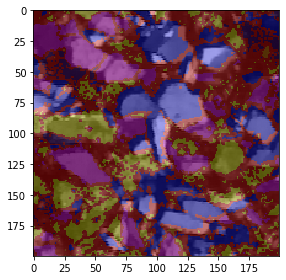

In [5]:
# visualize a training sample, i, with the segmentation mask overlayed
i = 15000
test = np.dstack((df['r_xpl'][i], df['g_xpl'][i], df['b_xpl'][i]))
io.imshow(color.label2rgb(df['labels'][i], test ))

In [6]:
test = np.array(Image.open('../dataset/train_segmentation/img_1.png'))
np.unique(test)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [16]:
input_height=200
input_width=200
img_input = tf.keras.Input(shape=(input_height, input_width, 3))

n_classes = 7


In [17]:
# define encoder layers
# conv1 and conv2 contain intermediate the encoder outputs
# which will be used by the decoder
# pool2 is the final output of the encoder

# two convolution layers and one pooling layer, which downsamples image by a factor of 2
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = tf.keras.layers.Dropout(0.2)(conv1)
conv1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Dropout(0.2)(conv2)
conv2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)

# decoder layers
conv3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv3)

# concat intermediate encoder outputs with intermediate decoder outputs, which is the skip connection
up1 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D((2,2))(conv3), conv2], axis=-1)
conv4 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(up1)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv4)

up2 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D((2,2))(conv4), conv1], axis=-1)
conv5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(up2)
conv5 = tf.keras.layers.Dropout(0.2)(conv5)
conv5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv5)

# get output with proper number of classes
out = tf.keras.layers.Conv2D(n_classes, (1,1), padding='same')(conv5)

In [41]:
unet_model = vgg_unet(n_classes=7, input_height=320, input_width=320)

58892288/58889256 [==============================] - 10s 0us/step


In [42]:
unet_model.train(
    train_images = '../dataset/train_images/',
    train_annotations = '../dataset/train_segmentation/',
    checkpoints_path = '../dataset/unet_checkpoints/vgg_unet_1',
    epochs = 5)

Verifying training dataset


100%|██████████| 13000/13000 [00:45<00:00, 285.13it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 1535s 3s/step - loss: 2.4553 - accuracy: 0.1149
saved  ../dataset/unet_checkpoints/vgg_unet_1.0
Epoch 2/5
512/512 [==============================] - 1668s 3s/step - loss: 2.2059 - accuracy: 0.2483
saved  ../dataset/unet_checkpoints/vgg_unet_1.1
Epoch 3/5
512/512 [==============================] - 1788s 3s/step - loss: 2.0624 - accuracy: 0.3213
saved  ../dataset/unet_checkpoints/vgg_unet_1.2
Epoch 4/5
512/512 [==============================] - 1840s 4s/step - loss: 1.9974 - accuracy: 0.3568
saved  ../dataset/unet_checkpoints/vgg_unet_1.3
Epoch 5/5
512/512 [==============================] - 1524s 3s/step - loss: 1.9374 - accuracy: 0.3521
saved  ../dataset/unet_checkpoints/vgg_unet_1.4


In [18]:
# custom model
xpl_model = get_segmentation_model(img_input, out)
xpl_model.train(
    train_images = '../dataset/xpl_train_images/',
    train_annotations = '../dataset/train_segmentation/',
    checkpoints_path = '../dataset/custom_checkpoints/xpl_net',
    epochs = 5)

Verifying training dataset
100%|██████████| 13000/13000 [00:44<00:00, 289.47it/s]
/Users/kacikus/.virtualenvs/automin_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Dataset verified! 
Epoch 1/5
512/512 [==============================] - 450s 877ms/step - loss: 7.5029 - accuracy: 0.4523
saved  ../dataset/custom_checkpoints/xpl_net.0
Epoch 2/5
512/512 [==============================] - 407s 795ms/step - loss: 2.8714 - accuracy: 0.4086
saved  ../dataset/custom_checkpoints/xpl_net.1
Epoch 3/5
512/512 [==============================] - 421s 822ms/step - loss: 1.8959 - accuracy: 0.4239
saved  ../dataset/custom_checkpoints/xpl_net.2
Epoch 4/5
512/512 [==============================] - 407s 795ms/step - loss: 1.6141 - accuracy: 0.4464
saved  ../dataset/custom_chec

### Model with 6 color channels of PPL and XPL images

In [12]:
practice = train['img']

In [26]:
practice.shape

(17260,)

In [15]:
input_height=200
input_width=200
img_input = tf.keras.Input(shape=(input_height, input_width, 6))

n_classes = 7

# define encoder layers
# conv1 and conv2 contain intermediate the encoder outputs
# which will be used by the decoder
# pool2 is the final output of the encoder

# two convolution layers and one pooling layer, which downsamples image by a factor of 2
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = tf.keras.layers.Dropout(0.2)(conv1)
conv1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Dropout(0.2)(conv2)
conv2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)

# decoder layers
conv3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv3)

# concat intermediate encoder outputs with intermediate decoder outputs, which is the skip connection
up1 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D((2,2))(conv3), conv2], axis=-1)
conv4 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(up1)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv4)

up2 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D((2,2))(conv4), conv1], axis=-1)
conv5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(up2)
conv5 = tf.keras.layers.Dropout(0.2)(conv5)
conv5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv5)

# get output with proper number of classes
out = tf.keras.layers.Conv2D(n_classes, (1,1), padding='same')(conv5)

model_6chan = get_segmentation_model(img_input, out)
model_6chan.train(
    train_images=X_train,
    train_annotations=y_train,
    checkpoints_path='../dataset/custom_checkpoints/channel6_checkpoints',
    epochs=2
)

Verifying training dataset


ValueError: listdir: embedded null character in path

# look at model results

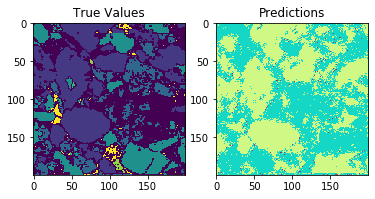

In [87]:
# self made model
i = 13200
# get prediction on test set
out = model.predict_segmentation(
    inp = f'../dataset/val_images/img_{i}.png',
    out_fname = 'output.png')

# load the test image
pred_img = Image.open('output.png').convert('RGB')

# load original image
orig_img = Image.open(f'../dataset/val_segmentation/img_{i}.png')

plt.subplot(1,2,1)
plt.title('True Values')
plt.imshow(orig_img)

plt.subplot(1,2,2)
plt.title('Predictions')
plt.imshow(pred_img)

accuracy ~53%

In [22]:
#vgg_unet results
i = 14888
# get prediction on test set
out = unet_model.predict_segmentation(
    inp = f'../dataset/val_images/img_{i}.png',
    out_fname = 'output.png')

# load the test image
pred_img = Image.open('output.png').convert('RGB')

# load original image
orig_img = Image.open(f'../dataset/val_segmentation/img_{i}.png')

plt.subplot(1,2,1)
plt.title('True Values')
plt.imshow(orig_img)

plt.subplot(1,2,2)
plt.title('Predictions')
plt.imshow(pred_img)

NameError: name 'unet_model' is not defined

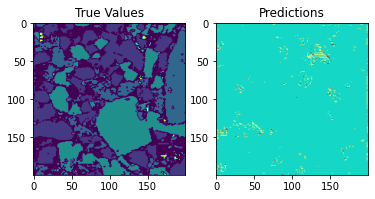

In [21]:
#xpl_model results
i = 14888
# get prediction on test set
out = xpl_model.predict_segmentation(
    inp = f'../dataset/xpl_val_images/img_{i}.png',
    out_fname = 'output.png')

# load the test image
pred_img = Image.open('output.png').convert('RGB')

# load original image
orig_img = Image.open(f'../dataset/val_segmentation/img_{i}.png')

plt.subplot(1,2,1)
plt.title('True Values')
plt.imshow(orig_img)

plt.subplot(1,2,2)
plt.title('Predictions')
plt.imshow(pred_img)

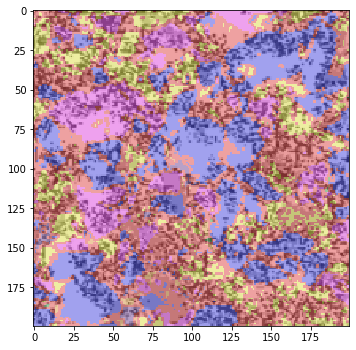

In [86]:
# show segmentated labels on the original image
plt.figure(figsize=(5, 5))
io.imshow(color.label2rgb(np.array(orig_img), np.array(pred_img)))

accuracy ~35%

In [71]:
# unique, counts = np.unique(np.array(test_img), axis = 0, return_counts=True)

# #frequencies = np.asarray((unique, counts))

# print(unique)